# Imports

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
import os
import seaborn as sns
from scipy.spatial.distance import cdist
from sklearn.impute import KNNImputer

# Importação do *Dataset*

In [22]:
data_path = '../data/' #if os.path.exists('../data/') #else 'https://raw.githubusercontent.com/TheAwesomeGe/DECD/main/data/'

cvd_df = pd.read_csv(data_path + 'CVD_cleaned.csv')

# Redução do *dataset* em 10%

In [23]:
cvd_df_10reduced = cvd_df.sample(frac=0.1, random_state=42)

# Redução do *dataset* em 20%

In [24]:
cvd_df_20reduced = cvd_df.sample(frac=0.1, random_state=42)

# Tratamento dos Valores Ausentes

## Estratégia 1: Substituir o valores ausentes pela média dos valores ou pela resposta categórica mais provável

### Dados ausentes do *dataset* reduzido em 10%

Encontrar os dados ausentes do *dataset* reduzido em 10%

In [25]:
dados_removidos = pd.merge(cvd_df, cvd_df_10reduced, how='outer', indicator=True).query('_merge == "left_only"').drop('_merge', axis=1)
print(dados_removidos)

       General_Health               Checkup Exercise Heart_Disease  \
0           Excellent   5 or more years ago       No            No   
1           Excellent   5 or more years ago       No            No   
2           Excellent   5 or more years ago       No            No   
3           Excellent   5 or more years ago       No            No   
4           Excellent   5 or more years ago       No            No   
...               ...                   ...      ...           ...   
308848      Very Good  Within the past year      Yes           Yes   
308849      Very Good  Within the past year      Yes           Yes   
308850      Very Good  Within the past year      Yes           Yes   
308852      Very Good  Within the past year      Yes           Yes   
308853      Very Good  Within the past year      Yes           Yes   

       Skin_Cancer Other_Cancer Depression Diabetes Arthritis     Sex  \
0               No           No         No       No        No  Female   
1            

Substituir os atributos numéricos eliminados por médias e os categóricos pela resposta mais frequente

In [26]:
# Identificar colunas numéricas
colunas_numericas = cvd_df_10reduced.select_dtypes(include=['float64', 'int64']).columns

# Substituir valores ausentes nas colunas numéricas pela média
for col in colunas_numericas:
    media = cvd_df_10reduced[col].mean()  # Calcular a média da coluna
    cvd_df_10reduced[col] = cvd_df_10reduced[col].fillna(media)  # Substituir valores ausentes pela média

# Identificar colunas categóricas
colunas_categoricas = cvd_df_10reduced.select_dtypes(include=['object']).columns

# Substituir valores ausentes nas colunas categóricas pela moda
for col in colunas_categoricas:
    moda = cvd_df_10reduced[col].mode()[0]  # Calcular a moda da coluna
    cvd_df_10reduced[col] = cvd_df_10reduced[col].fillna(moda)  # Substituir valores ausentes pela moda


# Garantir que o diretório existe
diretorio = './new_datasets/'
if not os.path.exists(diretorio):
    os.makedirs(diretorio)

# Salvar o dataset tratado em um arquivo CSV
arquivo_destino = diretorio + 'CVD_10reduced_tratado.csv'
cvd_df_10reduced.to_csv(arquivo_destino, index=False)


Comparação entre o *dataset* original e o *dataset* reduzido em 10%

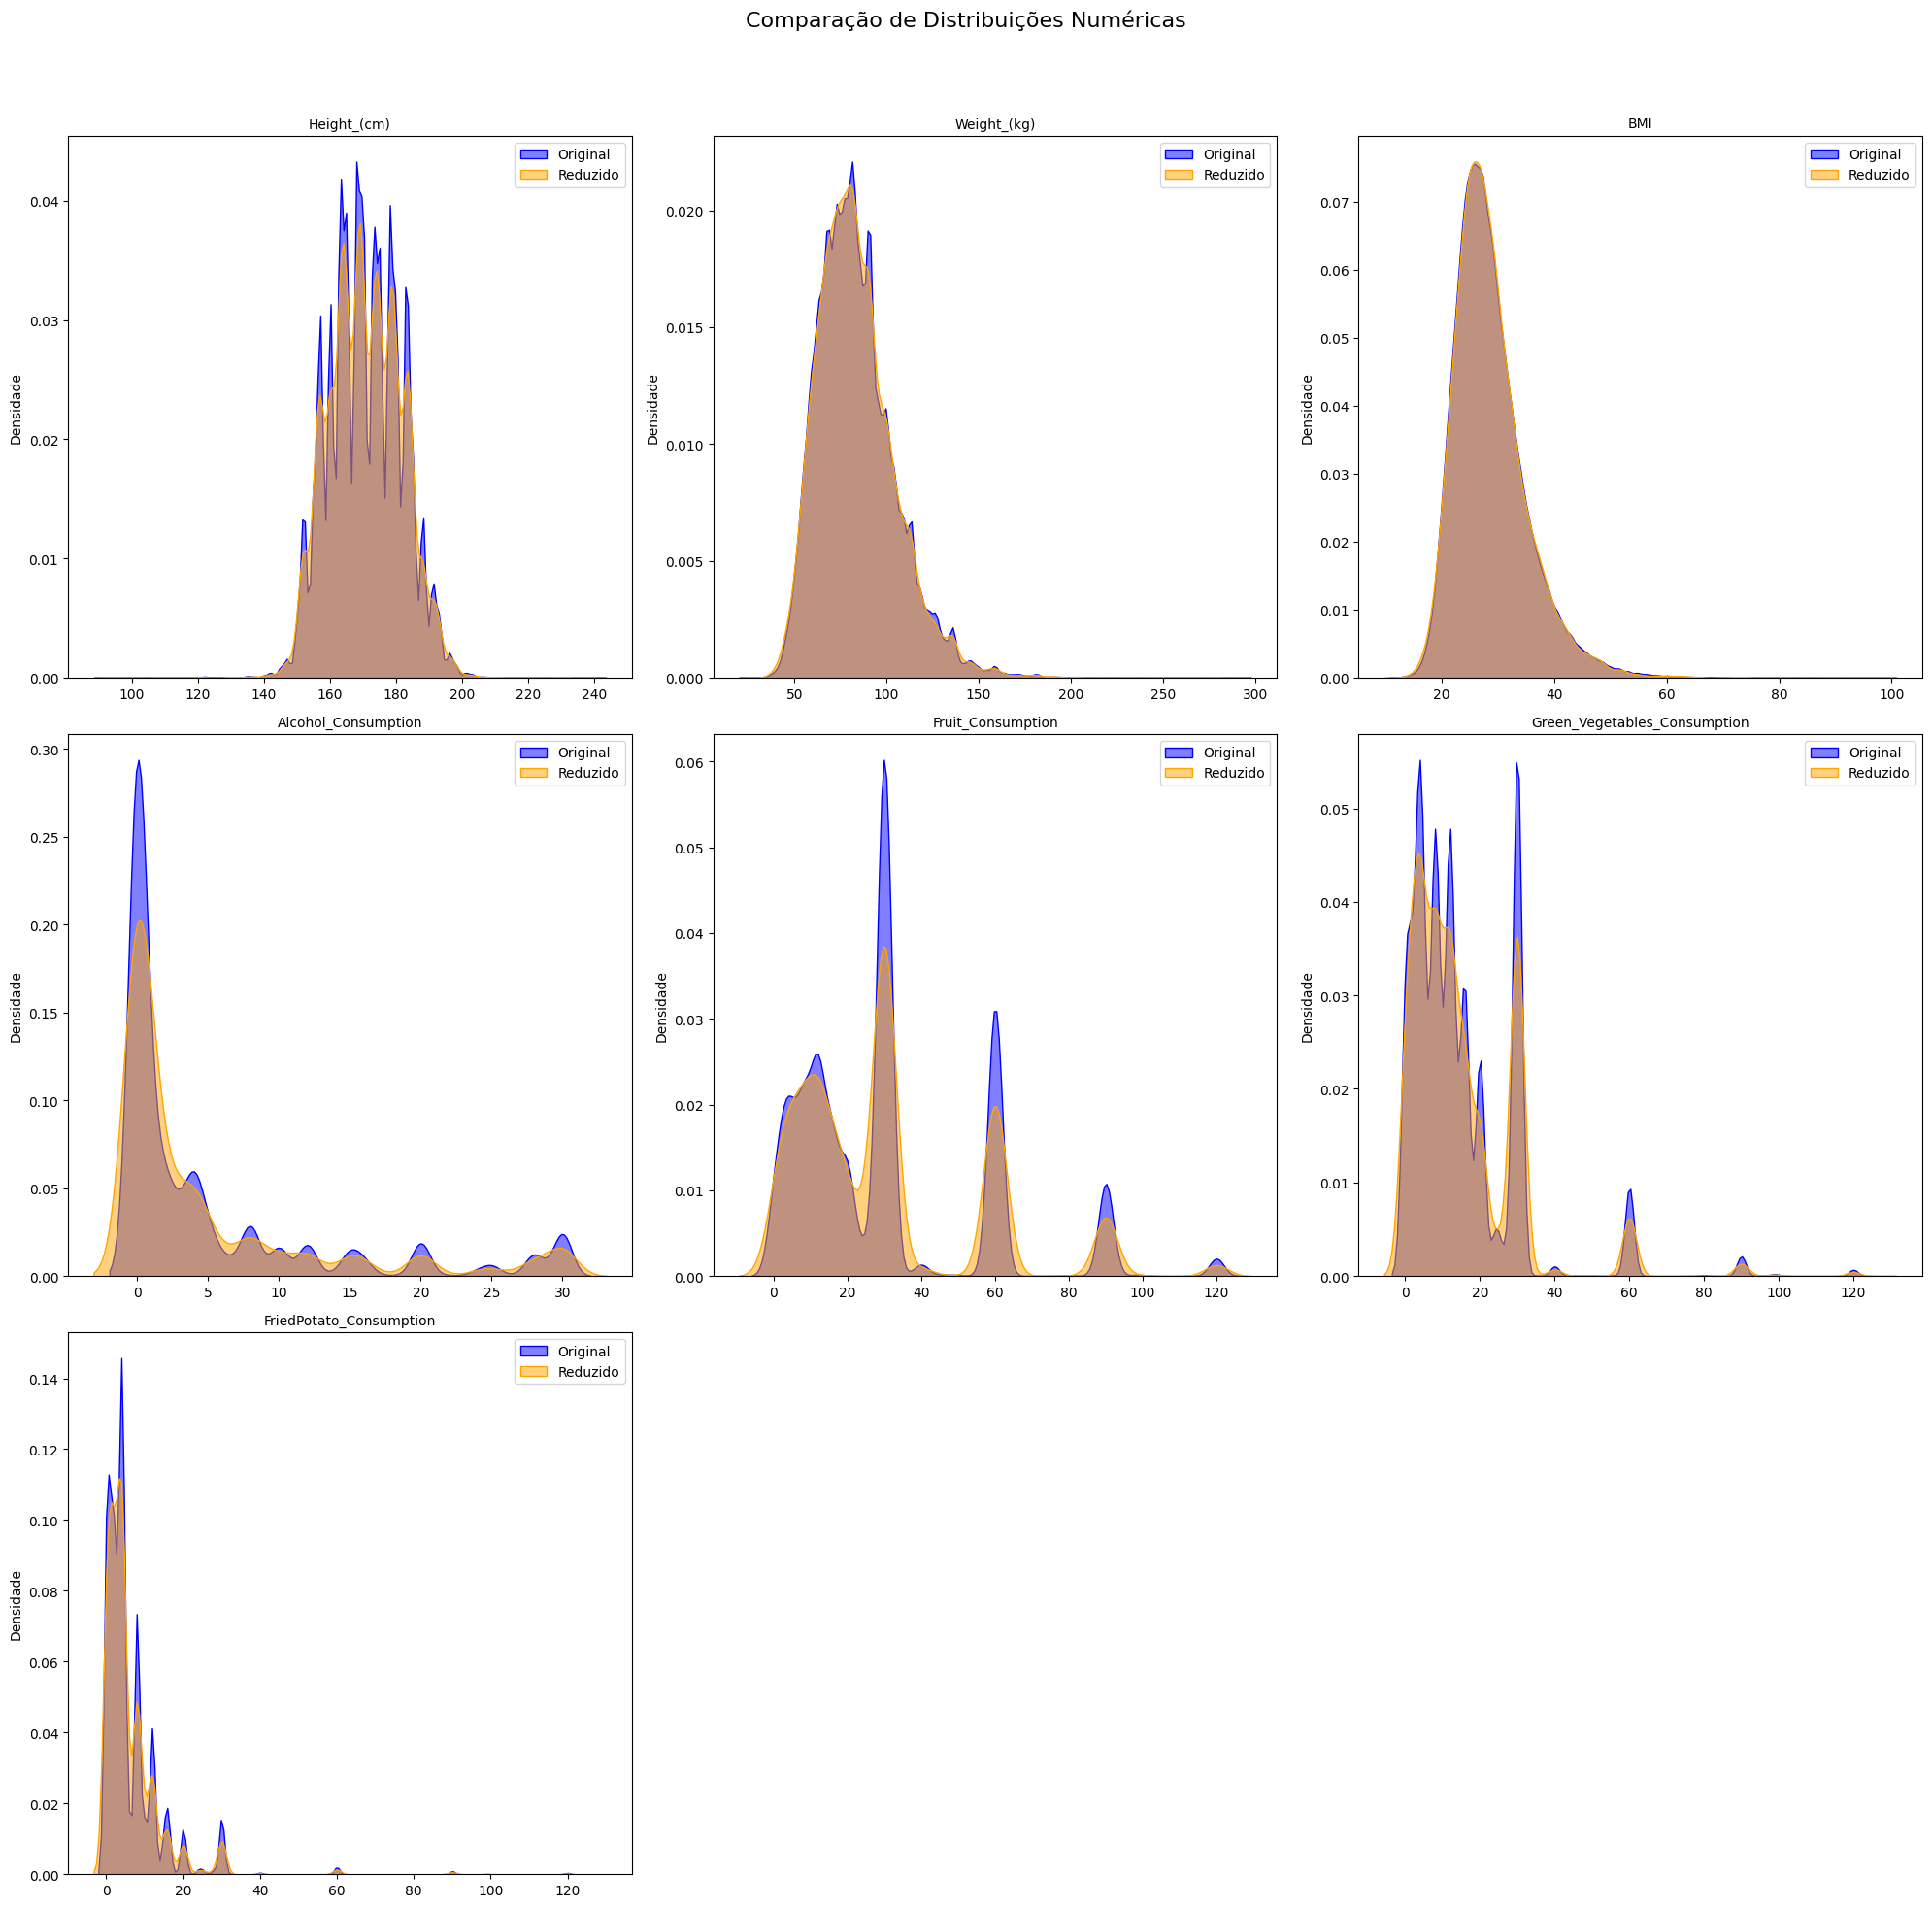

In [27]:
def comparar_distribuicoes_subplot(df_original, df_reduzido, colunas):
    n_colunas = len(colunas)
    rows, cols = 3, 3  # Layout de subplots
    fig, axes = plt.subplots(rows, cols, figsize=(20, 20))
    fig.suptitle("Comparação de Distribuições Numéricas", fontsize=16)

    # Garantir que axes seja iterável mesmo para poucos subplots
    axes = axes.flatten()

    for i, col in enumerate(colunas):
        ax = axes[i]

        sns.kdeplot(df_original[col], label='Original', fill=True, color='blue', alpha=0.5, ax=ax)
        sns.kdeplot(df_reduzido[col], label='Reduzido', fill=True, color='orange', alpha=0.5, ax=ax)

        ax.set_title(col, fontsize=10)
        ax.set_xlabel('')
        ax.set_ylabel('Densidade')
        ax.legend()

    # Remover eixos vazios para gráficos sobrantes
    for j in range(len(colunas), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


# Identificar colunas numéricas e categóricas
colunas_numericas = cvd_df.select_dtypes(include=['float64', 'int64']).columns

# Comparar distribuições numéricas com subplots
comparar_distribuicoes_subplot(cvd_df, cvd_df_10reduced, colunas_numericas)



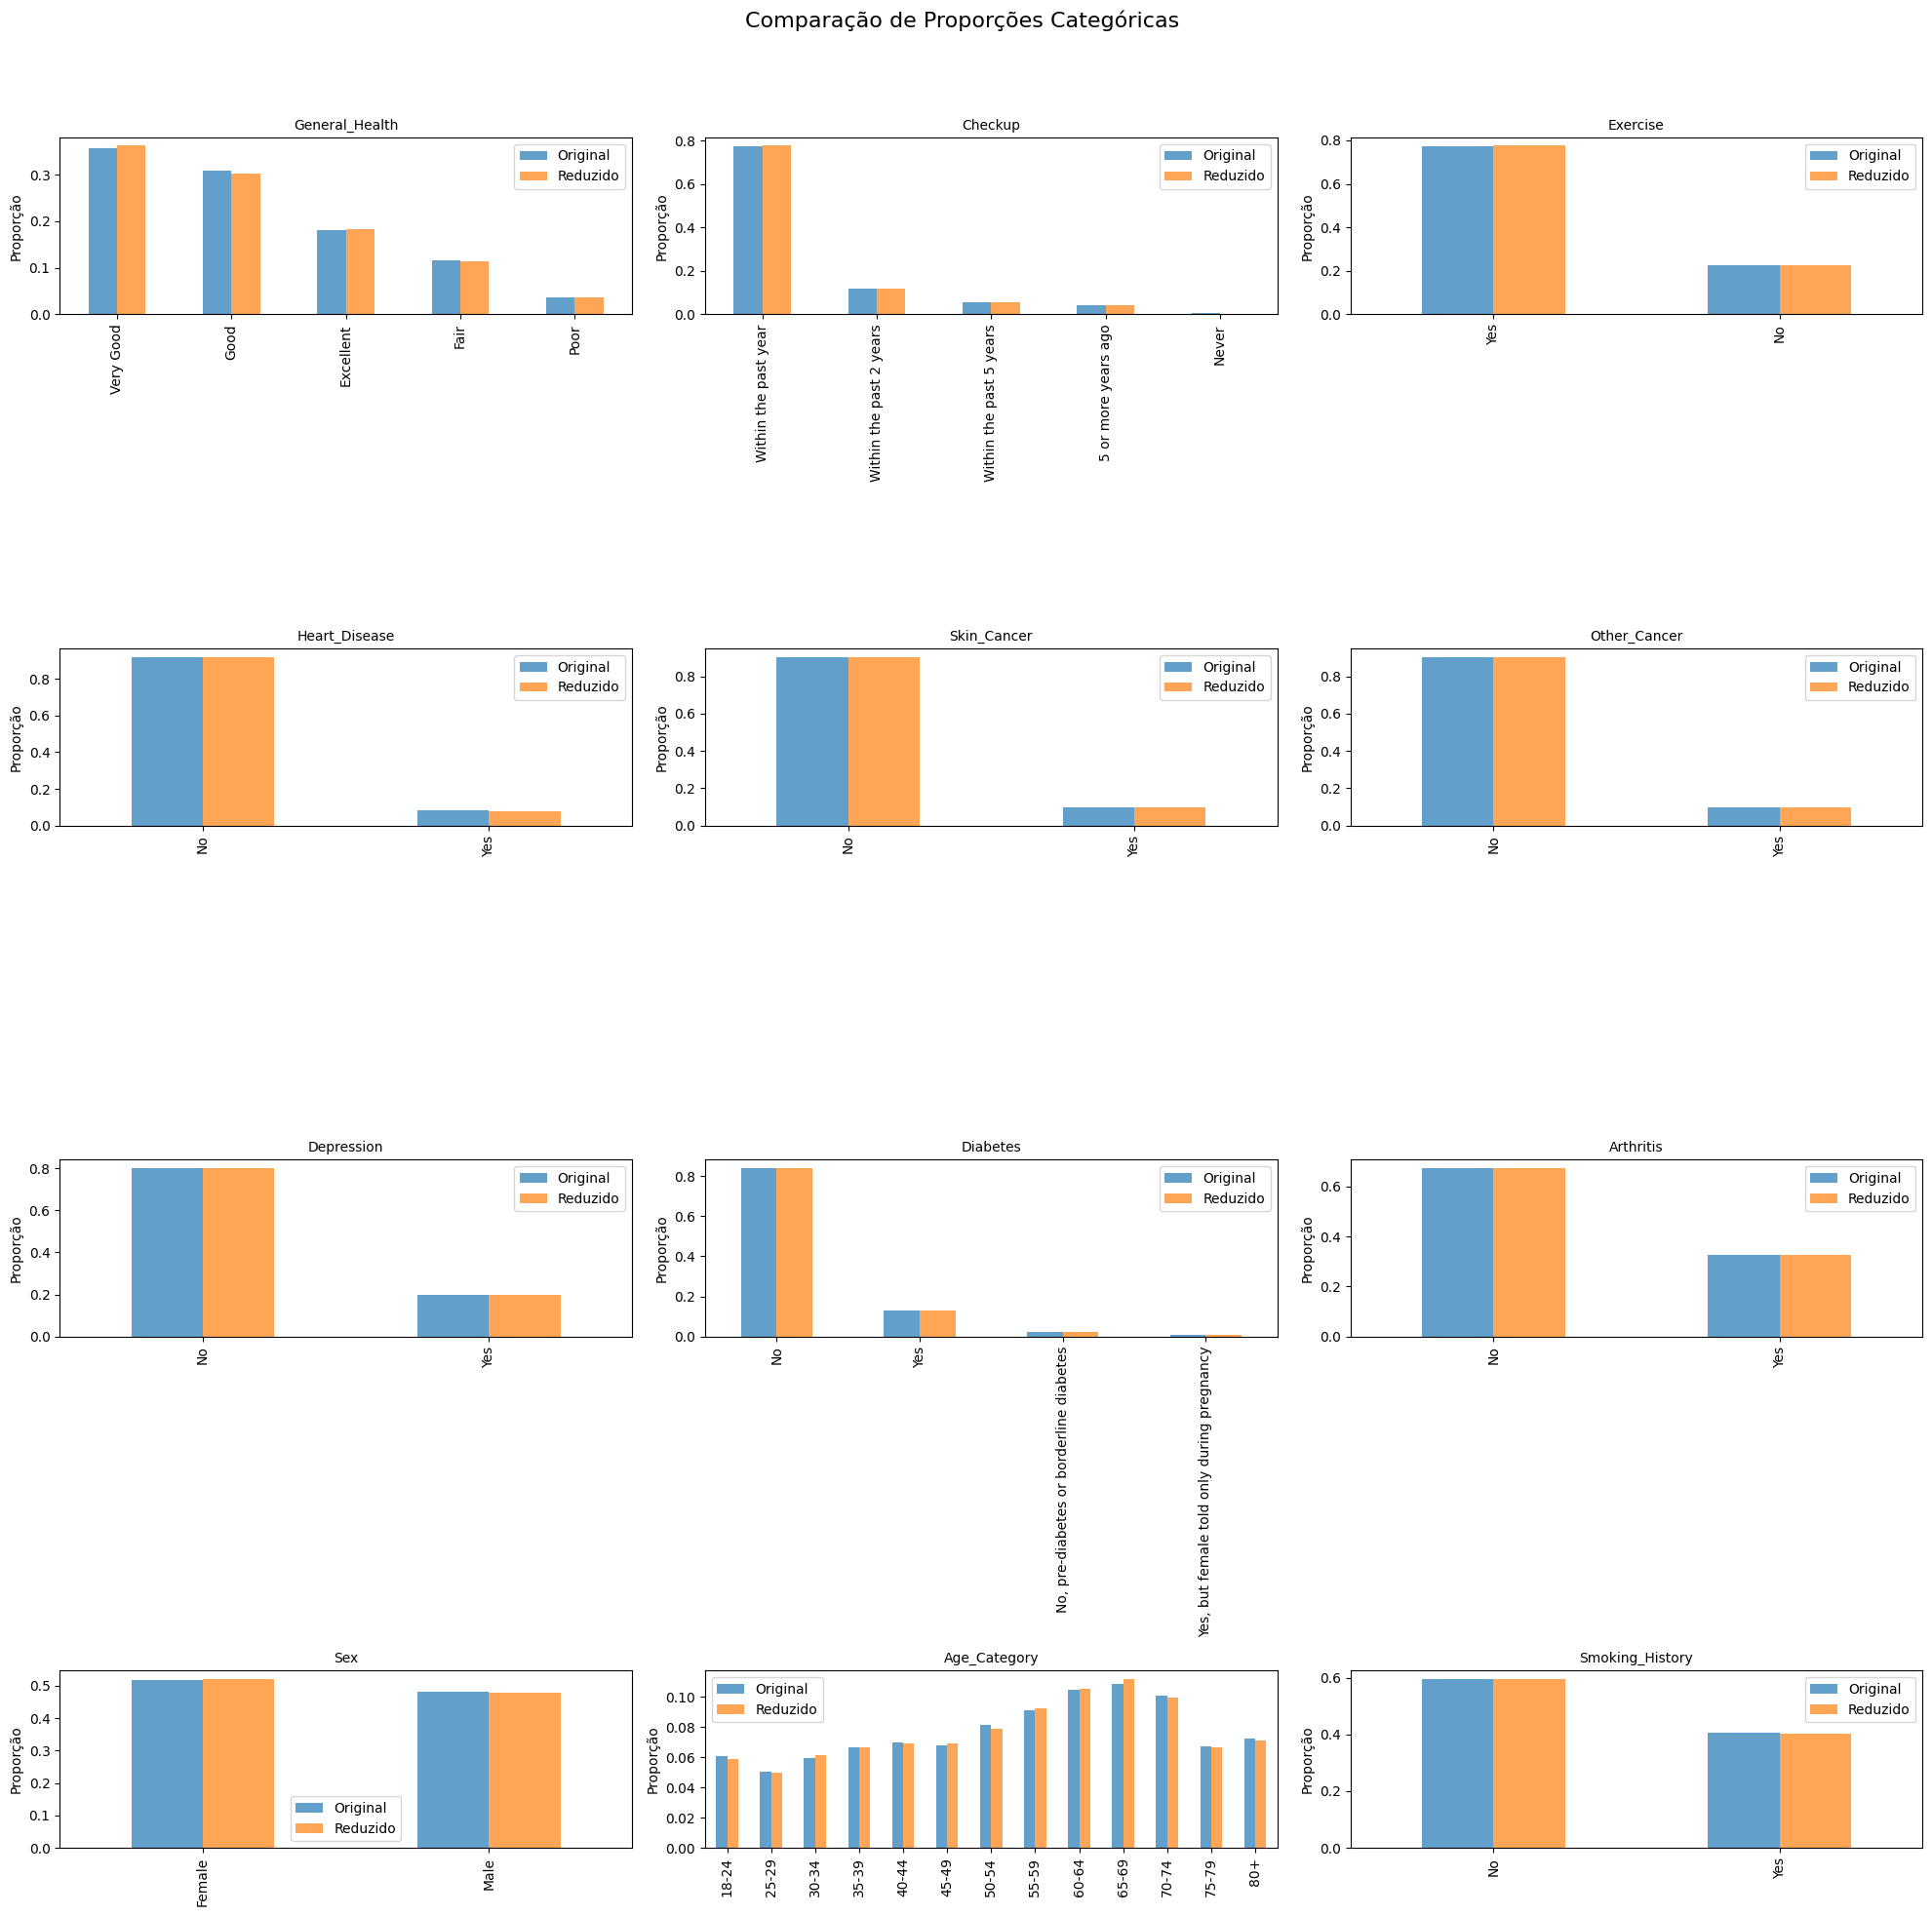

In [28]:
def comparar_proporcoes_subplot(df_original, df_reduzido, colunas):
    n_colunas = len(colunas)
    rows = (n_colunas // 3) + (1 if n_colunas % 3 != 0 else 0)  # Calcular dinamicamente o número de linhas
    cols = 3  # Número fixo de colunas

    fig, axes = plt.subplots(rows, cols, figsize=(20, 5 * rows))
    fig.suptitle("Comparação de Proporções Categóricas", fontsize=16)

    # Garantir que axes seja iterável mesmo para poucos subplots
    axes = axes.flatten()

    for i, col in enumerate(colunas):
        ax = axes[i]

        # Proporções no dataset original
        prop_original = df_original[col].value_counts(normalize=True)
        prop_reduzido = df_reduzido[col].value_counts(normalize=True)

        # Criar DataFrame para visualização
        prop_df = pd.DataFrame({'Original': prop_original, 'Reduzido': prop_reduzido})
        prop_df.plot(kind='bar', ax=ax, alpha=0.7)

        ax.set_title(col, fontsize=10)
        ax.set_xlabel('')
        ax.set_ylabel('Proporção')
        ax.legend()

    # Remover eixos vazios para gráficos sobrantes
    for j in range(len(colunas), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Identificar colunas categóricas
colunas_categoricas = cvd_df.select_dtypes(include=['object']).columns

# Comparar proporções categóricas com subplots
comparar_proporcoes_subplot(cvd_df, cvd_df_10reduced, colunas_categoricas)


### Dados ausentes do *dataset* reduzido em 20%

       General_Health               Checkup Exercise Heart_Disease  \
0           Excellent   5 or more years ago       No            No   
1           Excellent   5 or more years ago       No            No   
2           Excellent   5 or more years ago       No            No   
3           Excellent   5 or more years ago       No            No   
4           Excellent   5 or more years ago       No            No   
...               ...                   ...      ...           ...   
308848      Very Good  Within the past year      Yes           Yes   
308849      Very Good  Within the past year      Yes           Yes   
308850      Very Good  Within the past year      Yes           Yes   
308852      Very Good  Within the past year      Yes           Yes   
308853      Very Good  Within the past year      Yes           Yes   

       Skin_Cancer Other_Cancer Depression Diabetes Arthritis     Sex  \
0               No           No         No       No        No  Female   
1            

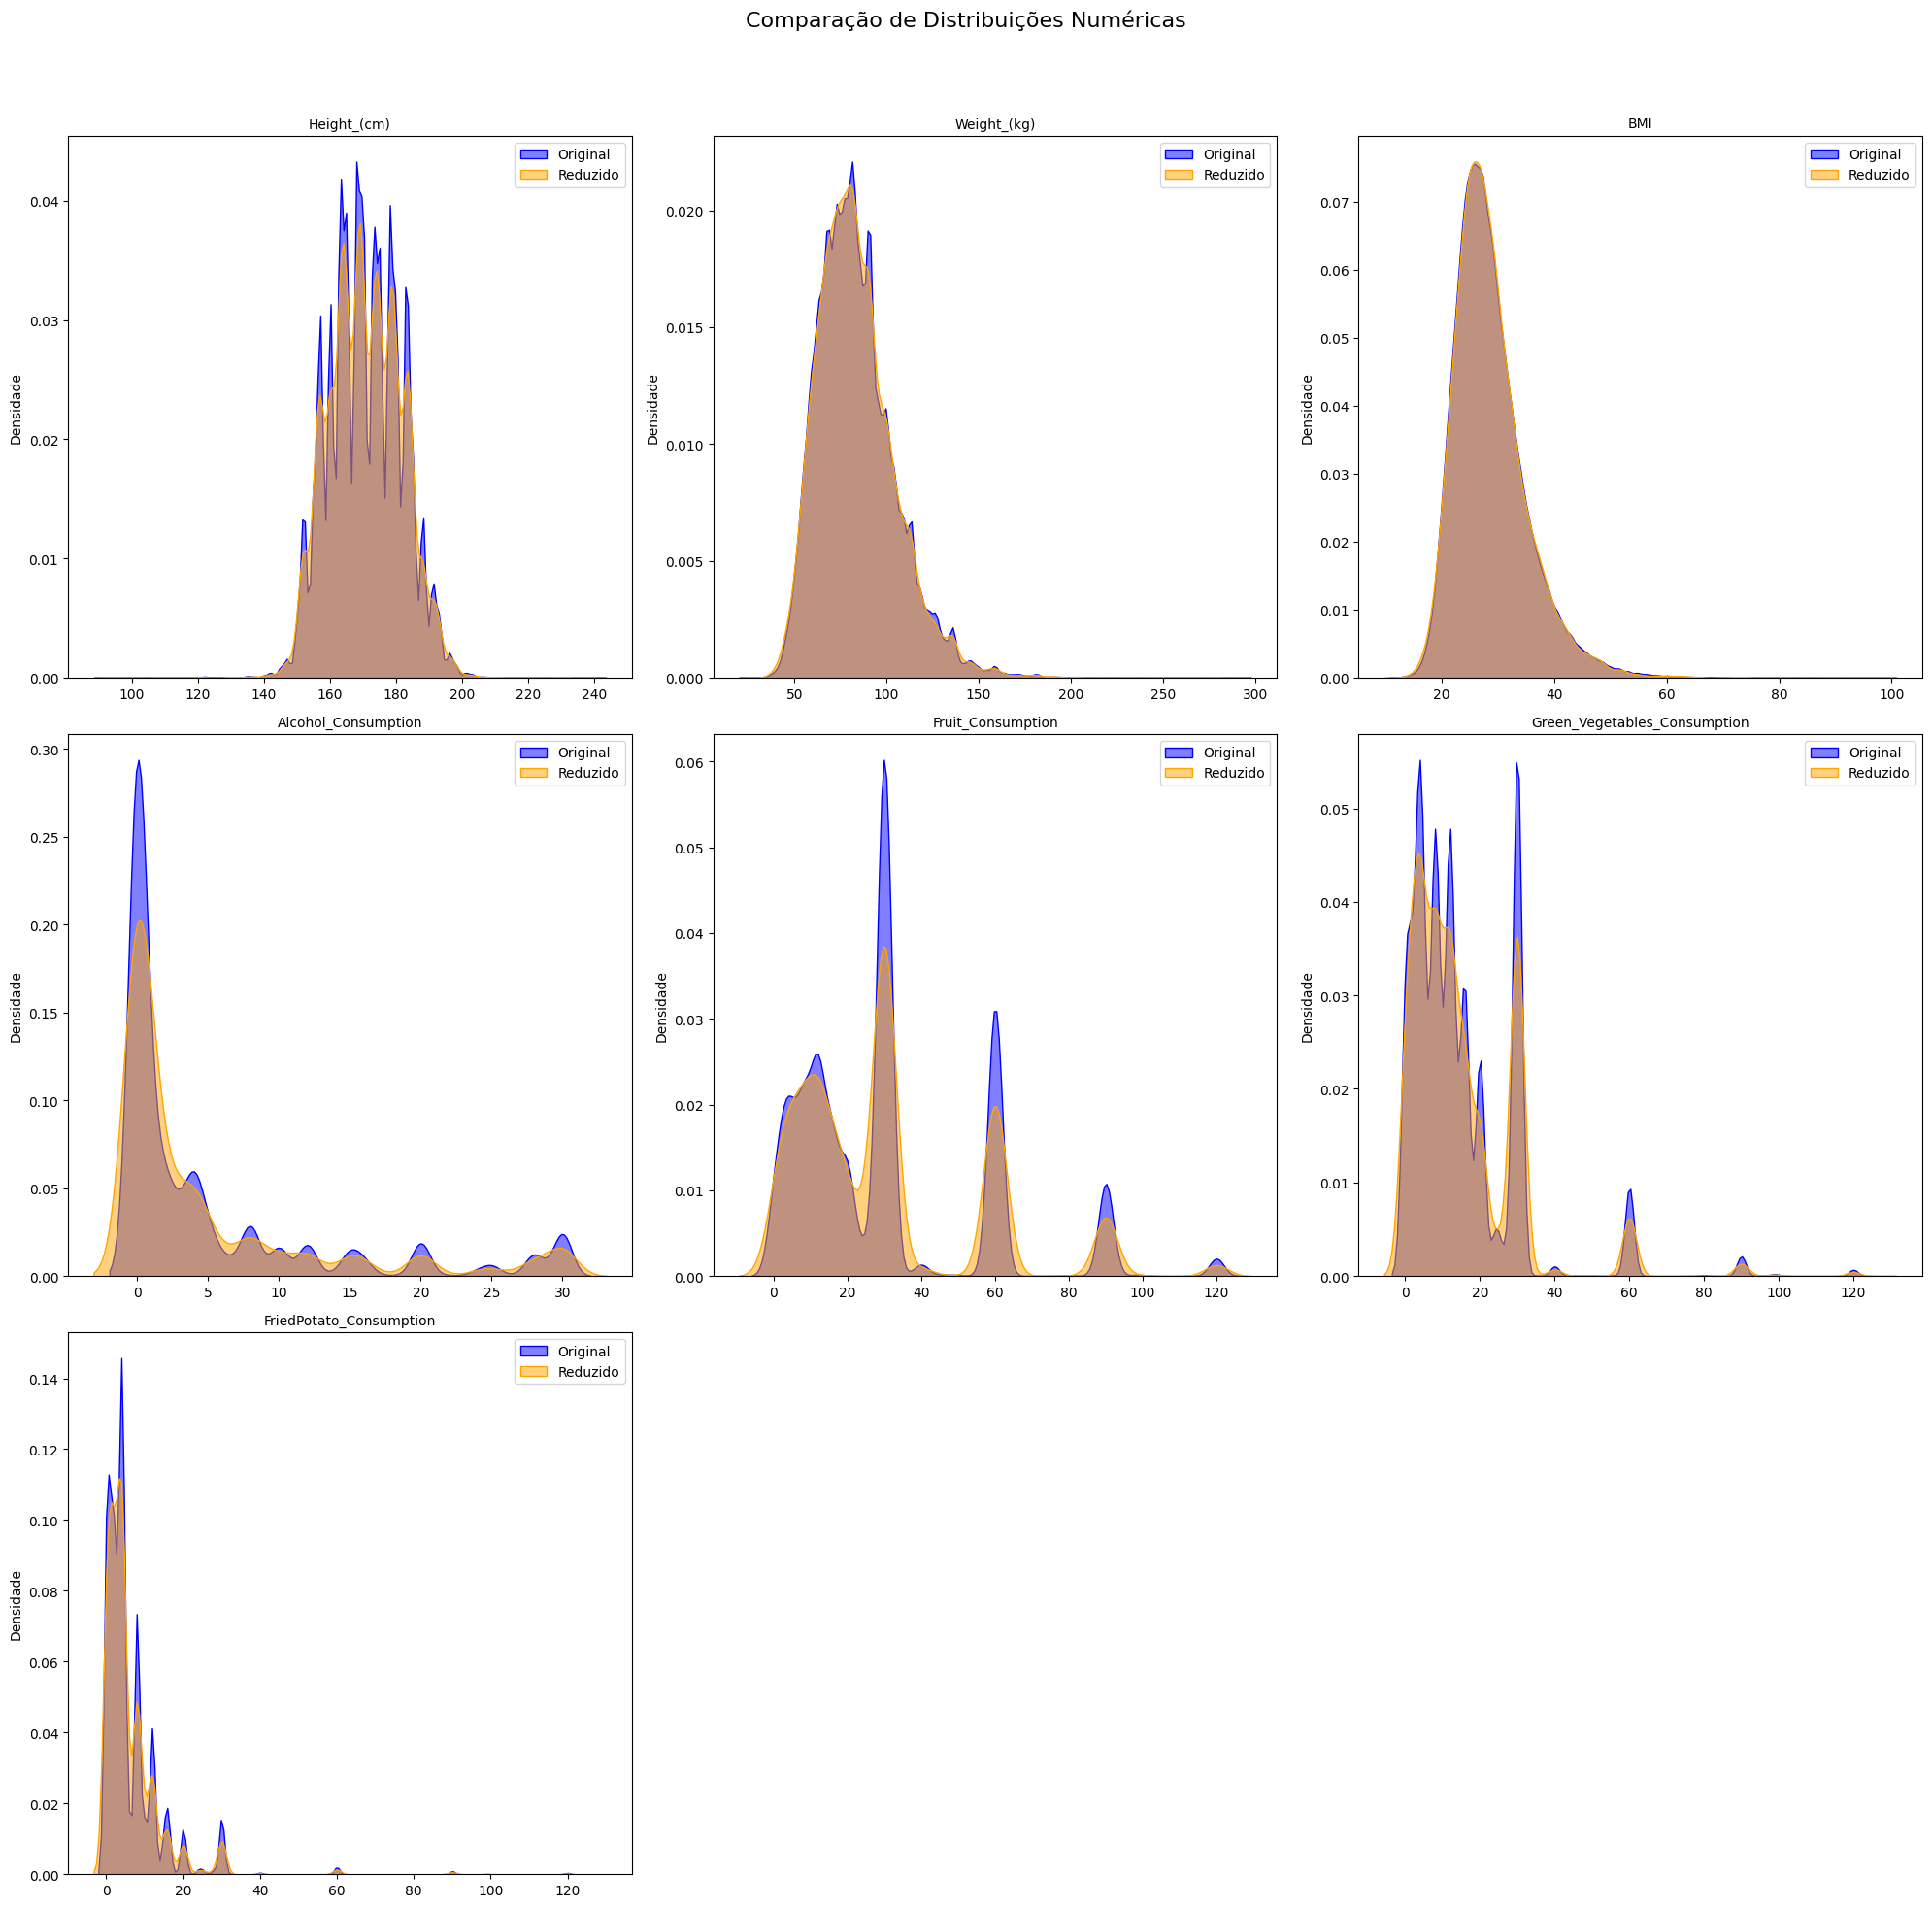

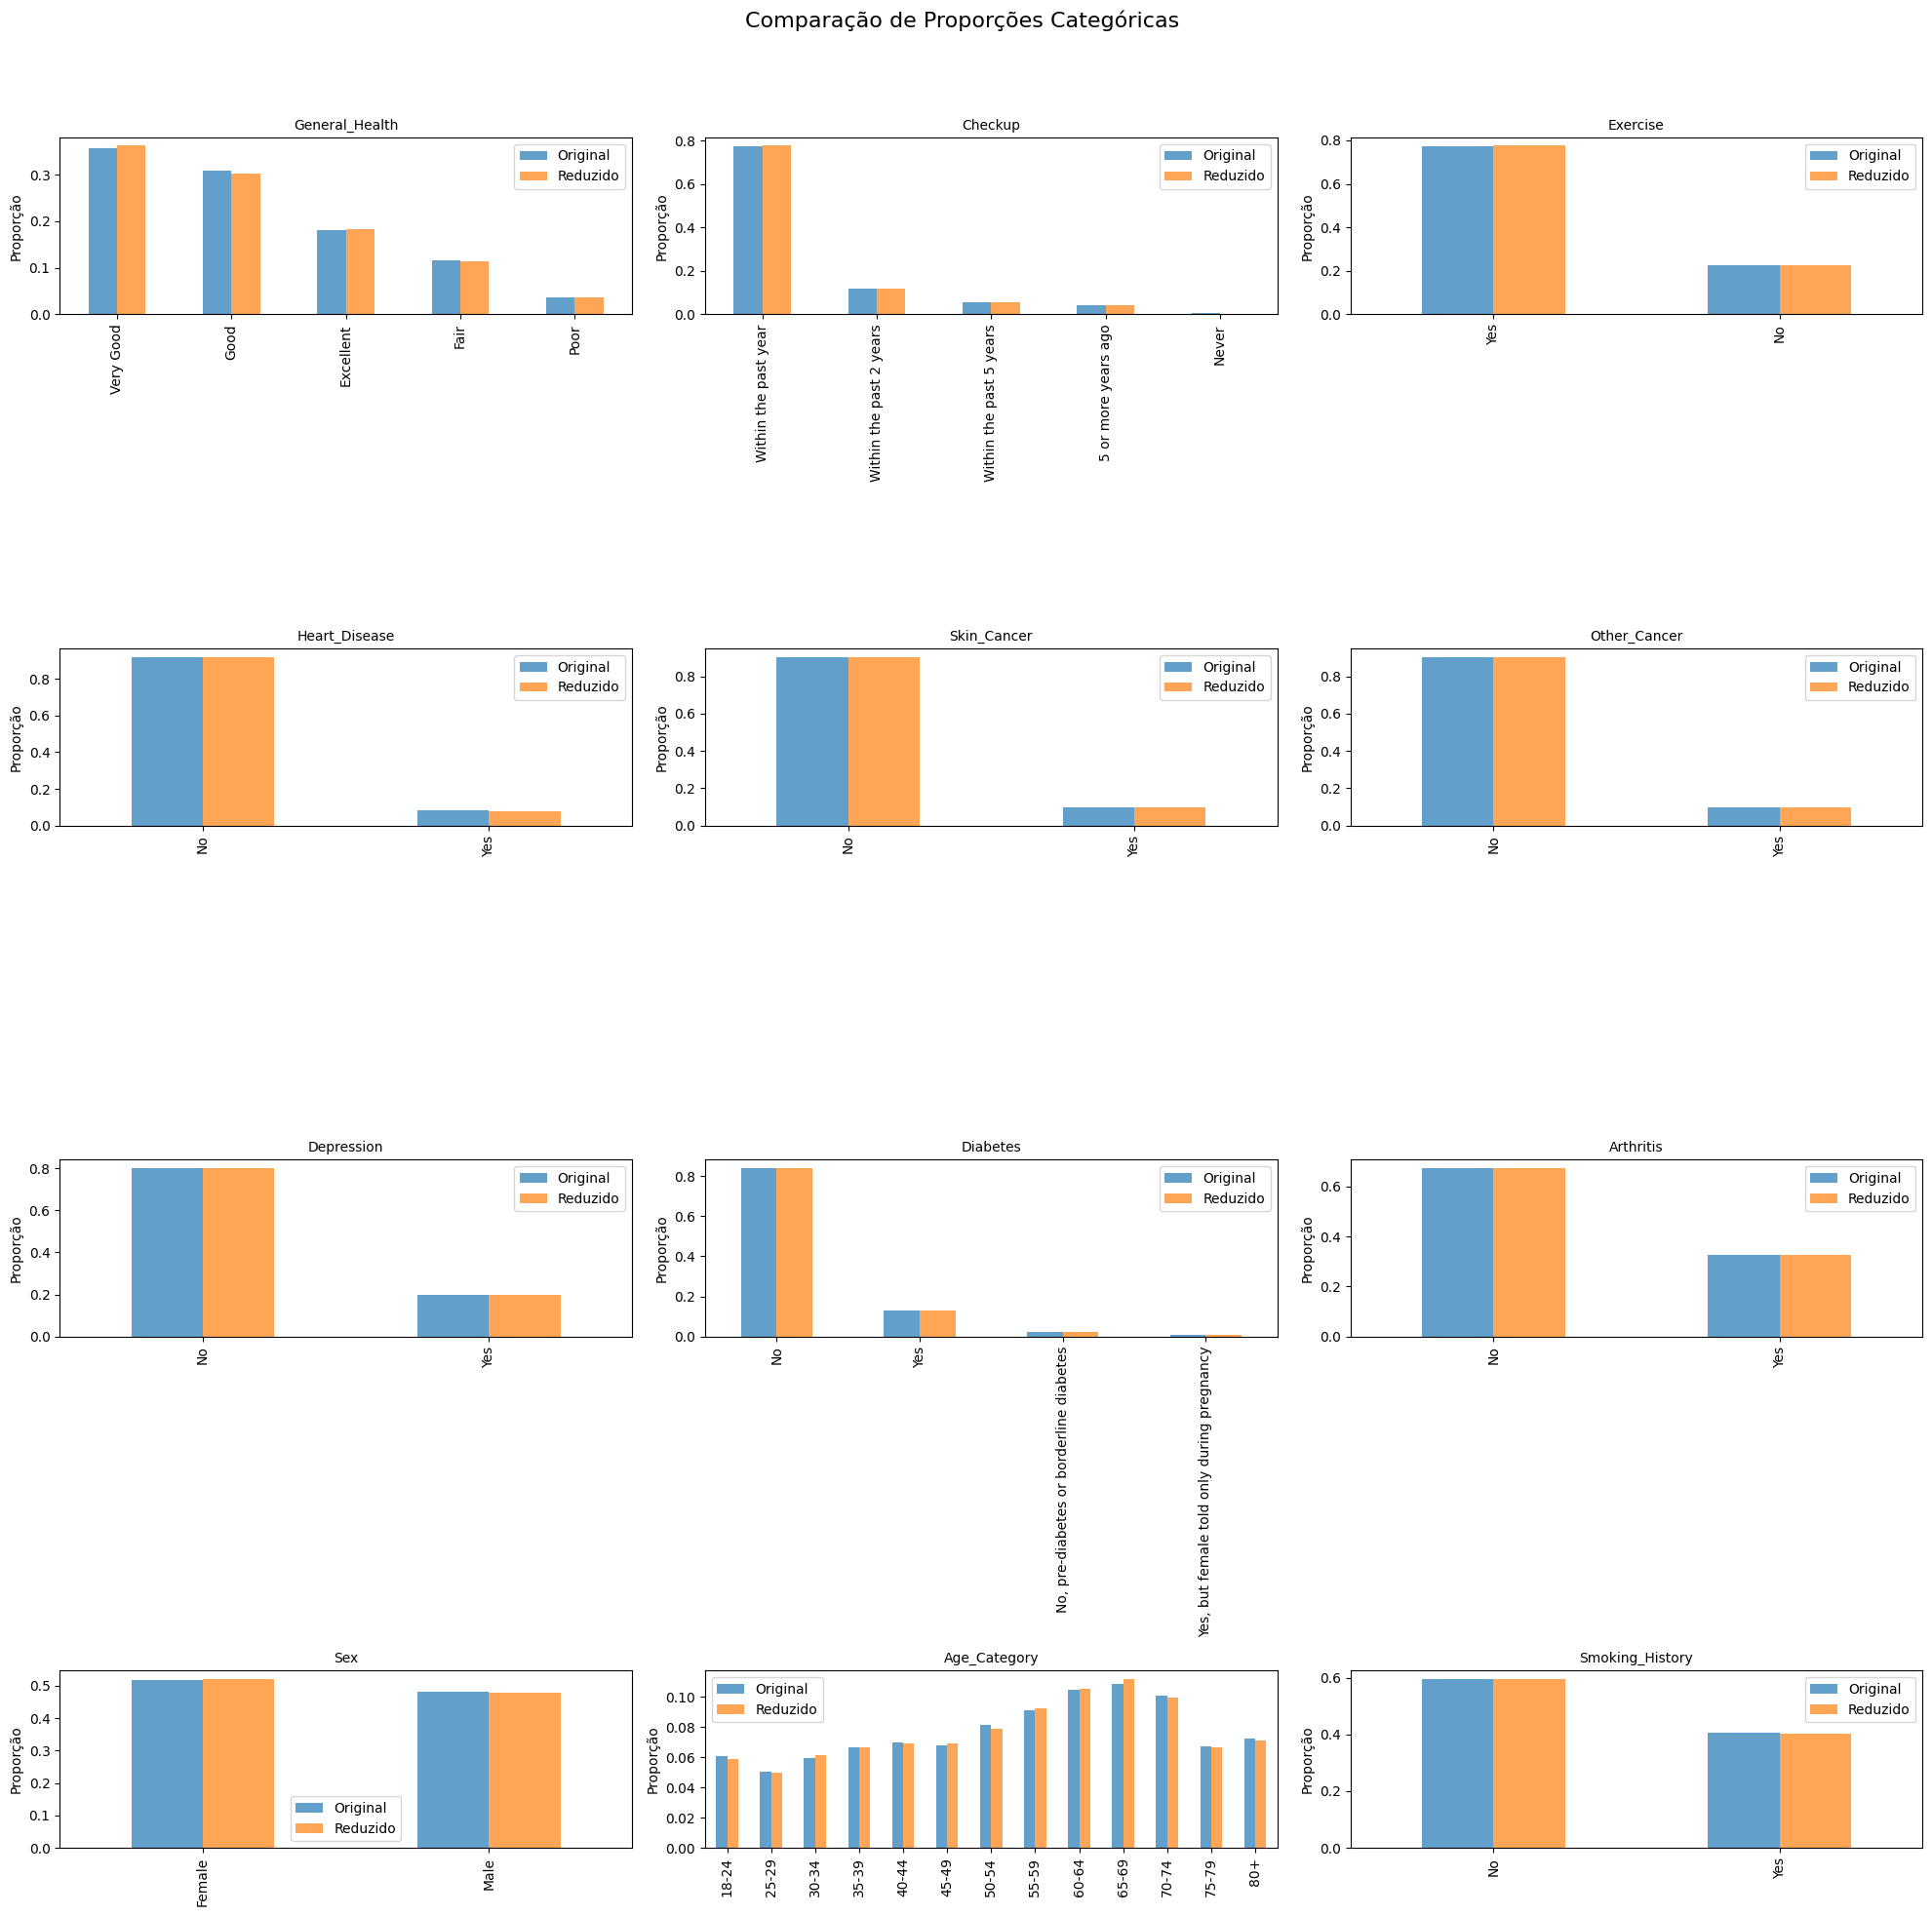

In [29]:
dados_removidos = pd.merge(cvd_df, cvd_df_20reduced, how='outer', indicator=True).query('_merge == "left_only"').drop('_merge', axis=1)
print(dados_removidos)

# Identificar colunas numéricas
colunas_numericas = cvd_df_20reduced.select_dtypes(include=['float64', 'int64']).columns

# Substituir valores ausentes nas colunas numéricas pela média
for col in colunas_numericas:
    media = cvd_df_20reduced[col].mean()  # Calcular a média da coluna
    cvd_df_10reduced[col] = cvd_df_20reduced[col].fillna(media)  # Substituir valores ausentes pela média

# Identificar colunas categóricas
colunas_categoricas = cvd_df_20reduced.select_dtypes(include=['object']).columns

# Substituir valores ausentes nas colunas categóricas pela moda
for col in colunas_categoricas:
    moda = cvd_df_20reduced[col].mode()[0]  # Calcular a moda da coluna
    cvd_df_20reduced[col] = cvd_df_20reduced[col].fillna(moda)  # Substituir valores ausentes pela moda


# Garantir que o diretório existe
diretorio = './new_datasets/'
if not os.path.exists(diretorio):
    os.makedirs(diretorio)

# Salvar o dataset tratado em um arquivo CSV
arquivo_destino = diretorio + 'CVD_20reduced_tratado.csv'
cvd_df_20reduced.to_csv(arquivo_destino, index=False)

# Identificar colunas numéricas e categóricas
colunas_numericas = cvd_df.select_dtypes(include=['float64', 'int64']).columns

# Comparar distribuições numéricas com subplots
comparar_distribuicoes_subplot(cvd_df, cvd_df_20reduced, colunas_numericas)

colunas_categoricas = cvd_df.select_dtypes(include=['object']).columns

# Comparar proporções categóricas com subplots
comparar_proporcoes_subplot(cvd_df, cvd_df_20reduced, colunas_categoricas)



## Estratégia 2: Aplicar o K-NN
* Para os atributos numéricos, aplicar o K-NN
* Para os atributos categóricas, usamos o modo (valor mais frequente) para preencher os valores ausentes.

### Dados ausentes do *dataset* reduzido em 10%

Encontrar os dados ausentes do *dataset* reduzido em 10%

In [30]:
dados_removidos = pd.merge(cvd_df, cvd_df_10reduced, how='outer', indicator=True).query('_merge == "left_only"').drop('_merge', axis=1)
print(dados_removidos)

       General_Health               Checkup Exercise Heart_Disease  \
0           Excellent   5 or more years ago       No            No   
1           Excellent   5 or more years ago       No            No   
2           Excellent   5 or more years ago       No            No   
3           Excellent   5 or more years ago       No            No   
4           Excellent   5 or more years ago       No            No   
...               ...                   ...      ...           ...   
308848      Very Good  Within the past year      Yes           Yes   
308849      Very Good  Within the past year      Yes           Yes   
308850      Very Good  Within the past year      Yes           Yes   
308852      Very Good  Within the past year      Yes           Yes   
308853      Very Good  Within the past year      Yes           Yes   

       Skin_Cancer Other_Cancer Depression Diabetes Arthritis     Sex  \
0               No           No         No       No        No  Female   
1            

In [31]:
numeric_columns = cvd_df_10reduced.select_dtypes(include=['float64', 'int64']).columns
categorical_columns = cvd_df_10reduced.select_dtypes(include=['object']).columns

# Para as colunas numéricas, vamos aplicar KNNImputer
imputer = KNNImputer(n_neighbors=5)
cvd_df_numeric_imputed = pd.DataFrame(imputer.fit_transform(cvd_df_10reduced[numeric_columns]), columns=numeric_columns)

# Para as colunas categóricas, vamos imputar pelo valor mais frequente (modo)
cvd_df_categorical_imputed = cvd_df_10reduced[categorical_columns].apply(lambda x: x.fillna(x.mode()[0]))
cvd_df_imputed = pd.concat([cvd_df_numeric_imputed, cvd_df_categorical_imputed], axis=1)

Comparação entre o *dataset* original e o *dataset* reduzido em 10%

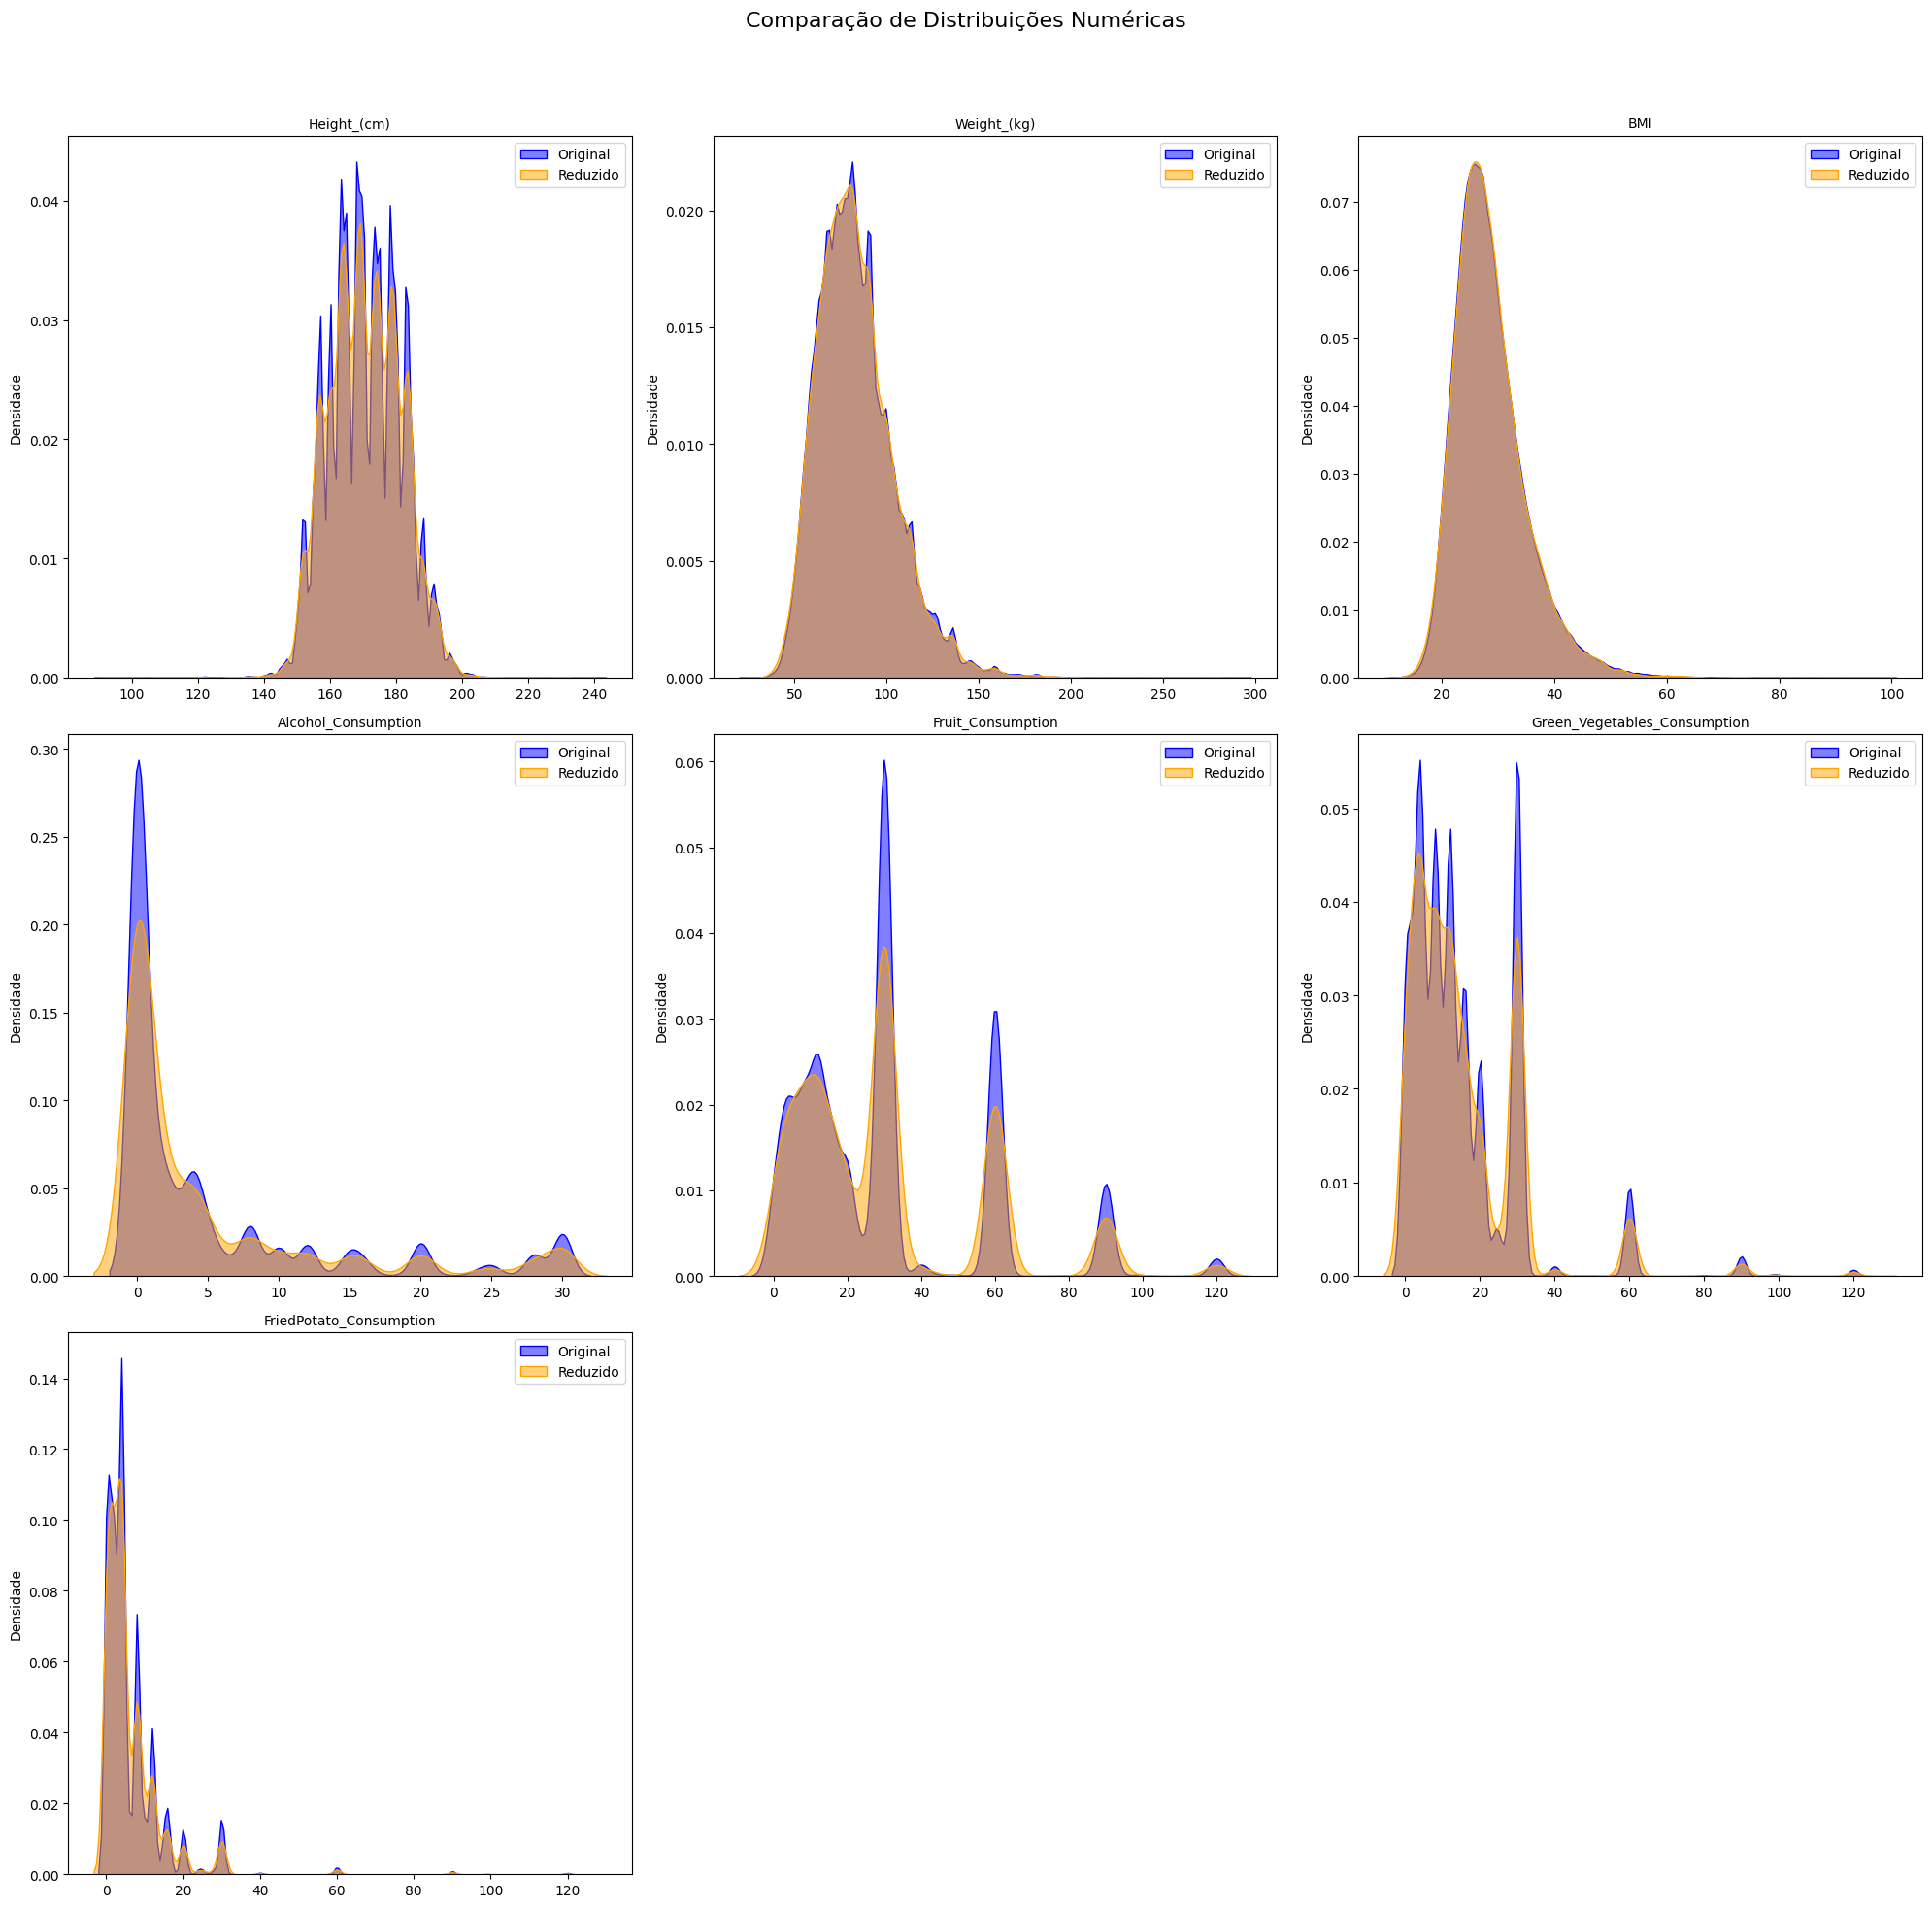

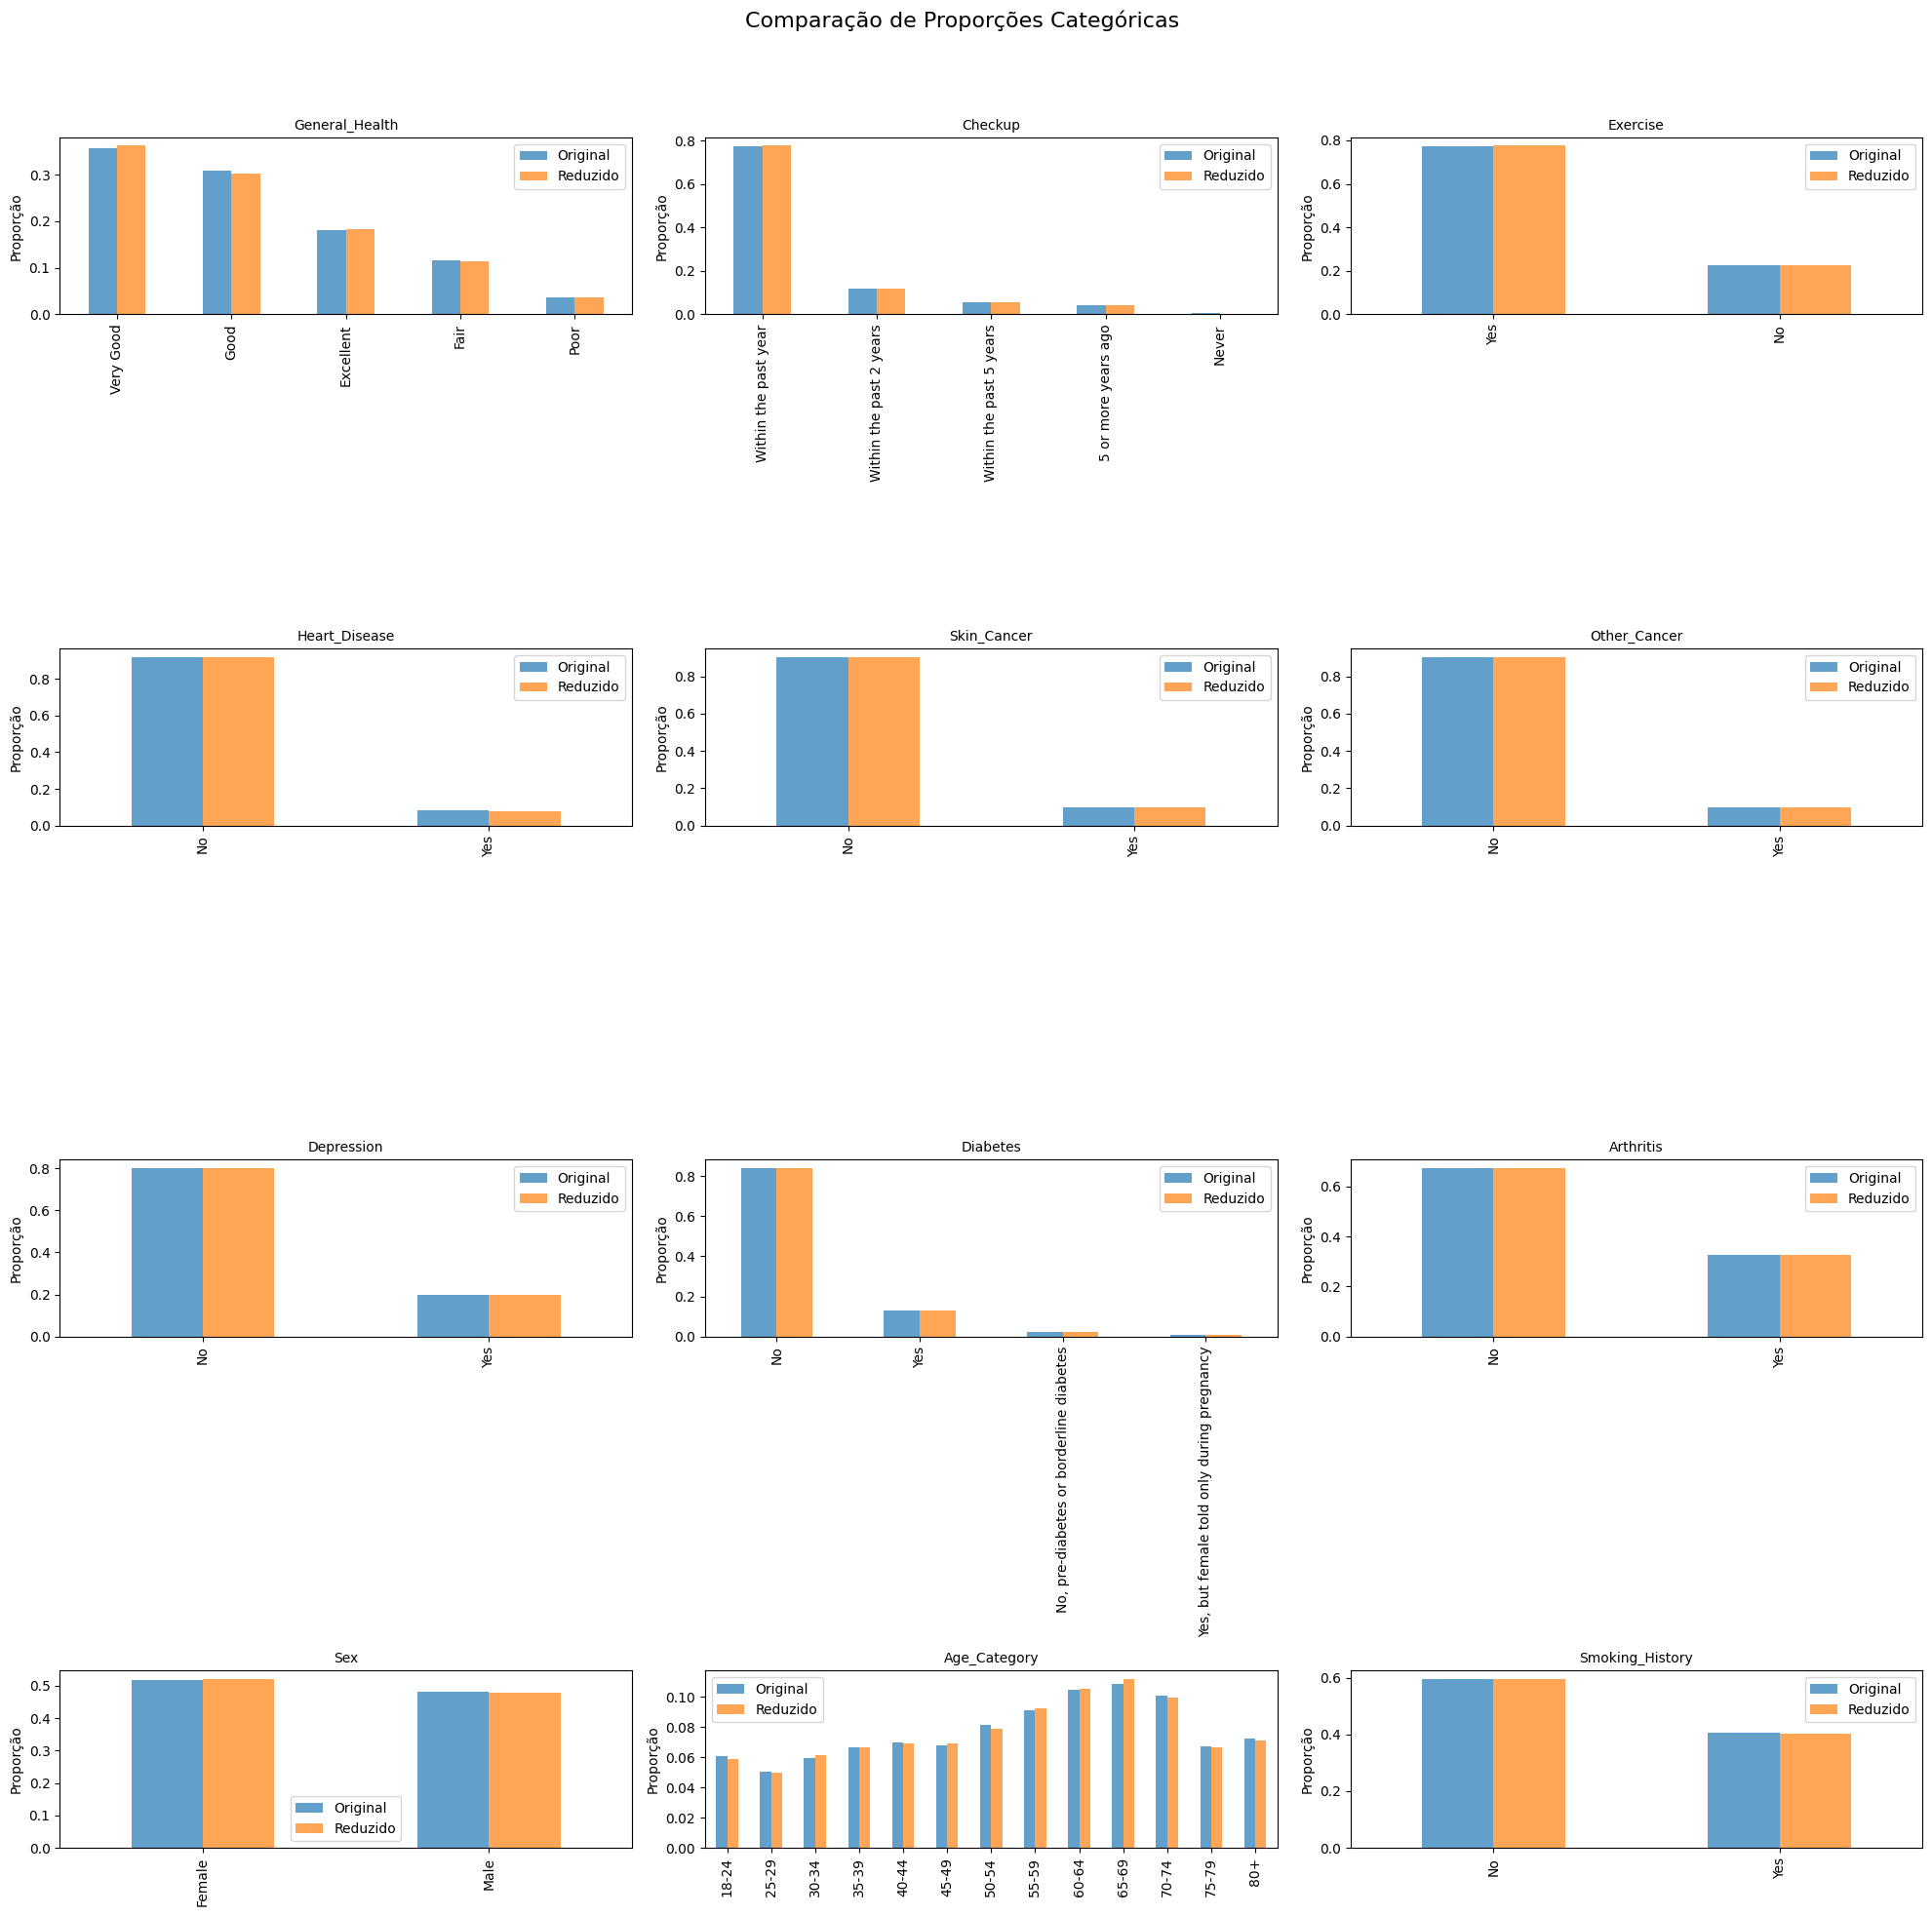

In [32]:
# Identificar colunas numéricas e categóricas
colunas_numericas = cvd_df.select_dtypes(include=['float64', 'int64']).columns

# Comparar distribuições numéricas com subplots
comparar_distribuicoes_subplot(cvd_df, cvd_df_numeric_imputed , colunas_numericas)

# Identificar colunas categóricas
colunas_categoricas = cvd_df.select_dtypes(include=['object']).columns

# Comparar proporções categóricas com subplots
comparar_proporcoes_subplot(cvd_df, cvd_df_categorical_imputed, colunas_categoricas)

### Dados ausentes do *dataset* reduzido em 20%

       General_Health               Checkup Exercise Heart_Disease  \
0           Excellent   5 or more years ago       No            No   
1           Excellent   5 or more years ago       No            No   
2           Excellent   5 or more years ago       No            No   
3           Excellent   5 or more years ago       No            No   
4           Excellent   5 or more years ago       No            No   
...               ...                   ...      ...           ...   
308848      Very Good  Within the past year      Yes           Yes   
308849      Very Good  Within the past year      Yes           Yes   
308850      Very Good  Within the past year      Yes           Yes   
308852      Very Good  Within the past year      Yes           Yes   
308853      Very Good  Within the past year      Yes           Yes   

       Skin_Cancer Other_Cancer Depression Diabetes Arthritis     Sex  \
0               No           No         No       No        No  Female   
1            

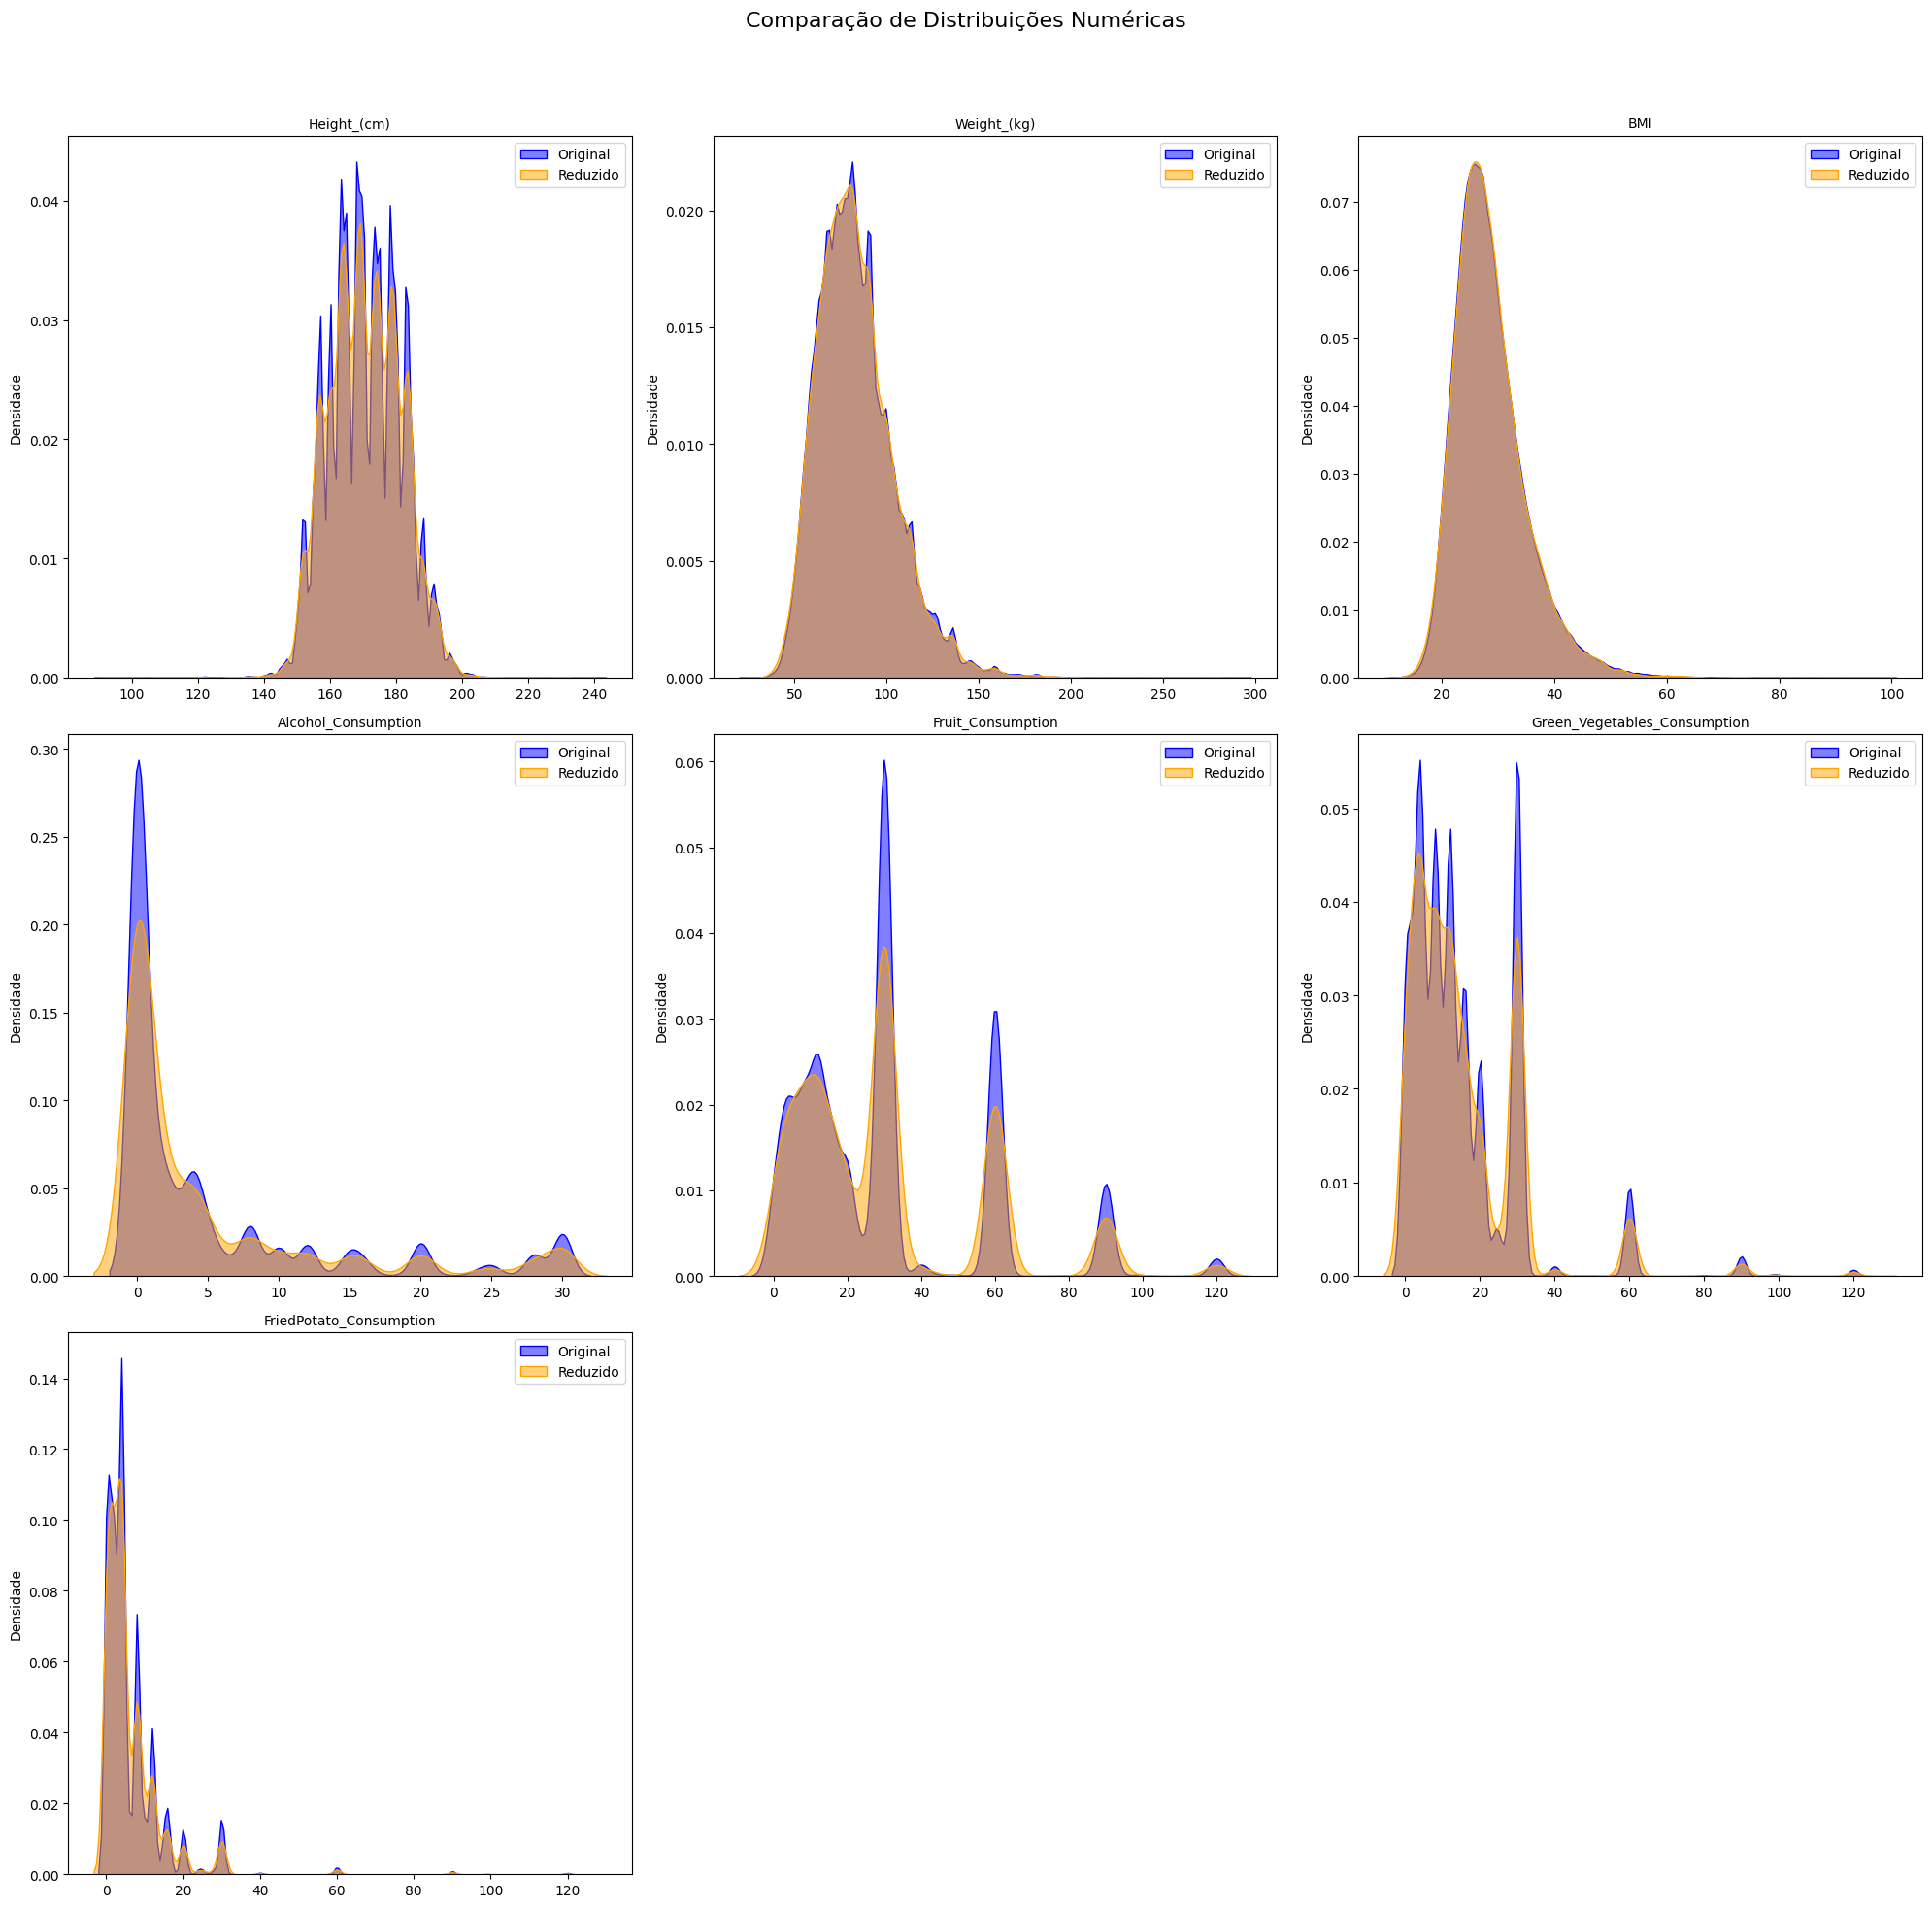

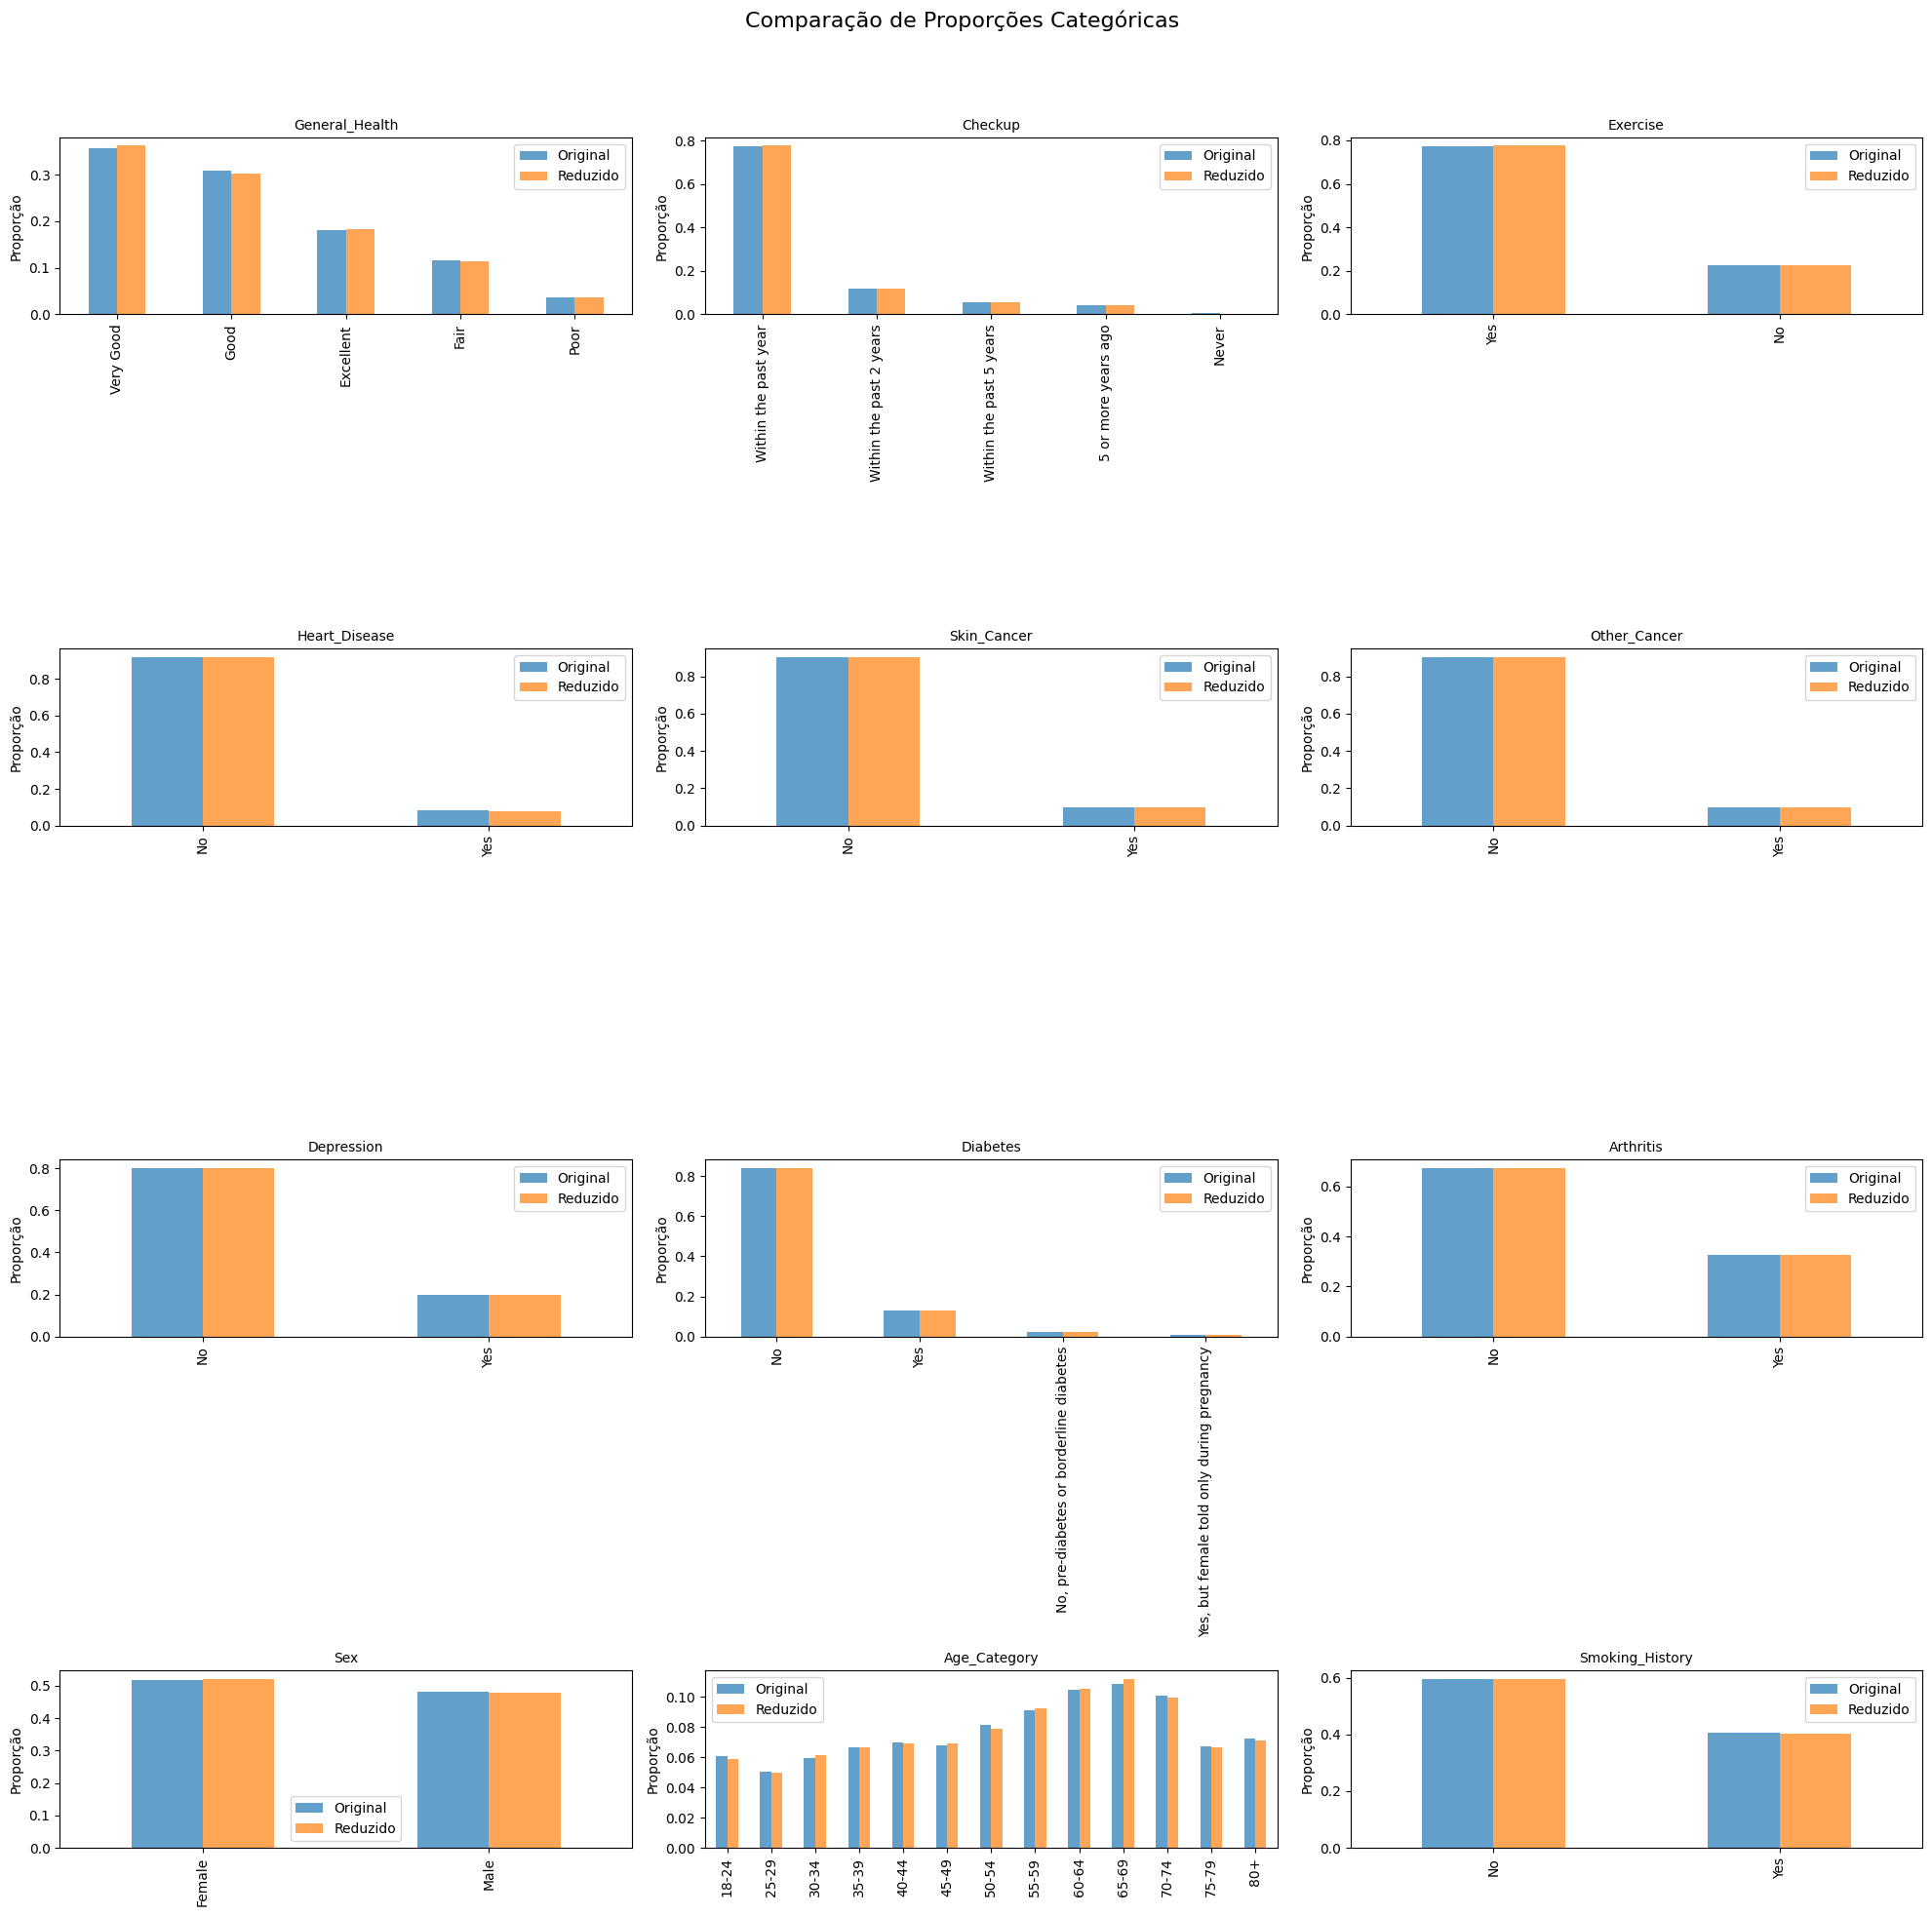

In [33]:
dados_removidos = pd.merge(cvd_df, cvd_df_20reduced, how='outer', indicator=True).query('_merge == "left_only"').drop('_merge', axis=1)
print(dados_removidos)

numeric_columns = cvd_df_20reduced.select_dtypes(include=['float64', 'int64']).columns
categorical_columns = cvd_df_20reduced.select_dtypes(include=['object']).columns

# Para as colunas numéricas, vamos aplicar KNNImputer
imputer = KNNImputer(n_neighbors=5)
cvd_df_numeric_imputed = pd.DataFrame(imputer.fit_transform(cvd_df_20reduced[numeric_columns]), columns=numeric_columns)

# Para as colunas categóricas, vamos imputar pelo valor mais frequente (modo)
cvd_df_categorical_imputed = cvd_df_20reduced[categorical_columns].apply(lambda x: x.fillna(x.mode()[0]))
cvd_df_imputed = pd.concat([cvd_df_numeric_imputed, cvd_df_categorical_imputed], axis=1)

# Identificar colunas numéricas e categóricas
colunas_numericas = cvd_df.select_dtypes(include=['float64', 'int64']).columns

# Comparar distribuições numéricas com subplots
comparar_distribuicoes_subplot(cvd_df, cvd_df_numeric_imputed , colunas_numericas)

# Identificar colunas categóricas
colunas_categoricas = cvd_df.select_dtypes(include=['object']).columns

# Comparar proporções categóricas com subplots
comparar_proporcoes_subplot(cvd_df, cvd_df_categorical_imputed, colunas_categoricas)